# **VoltSense**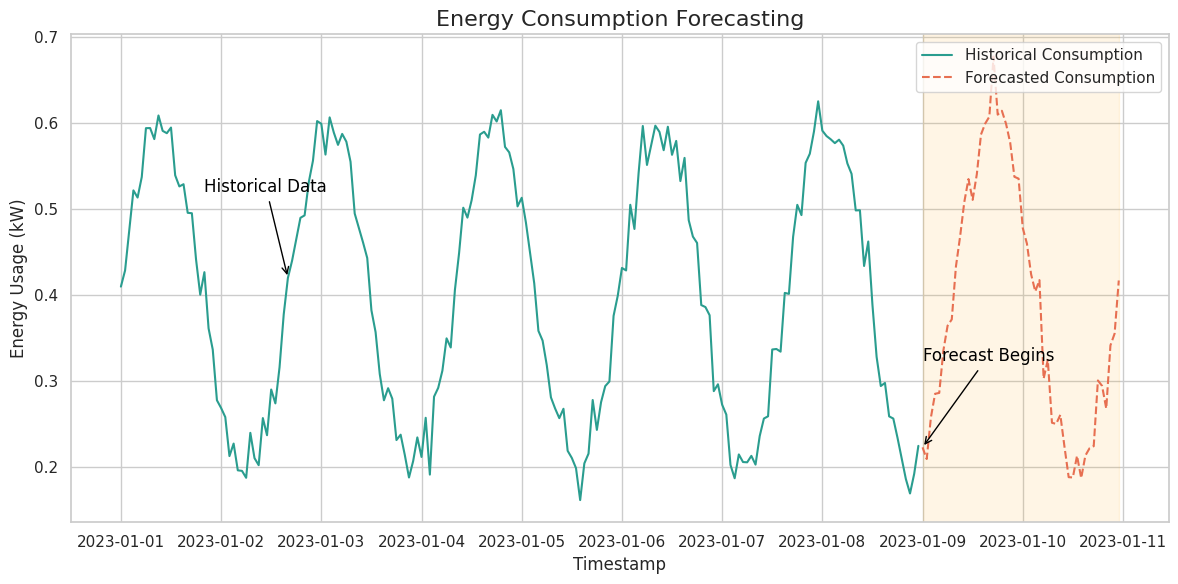




# **# Introduction**

--> In the era of smart grids and sustainable energy solutions, `accurate electricity consumption forecasting` is vital for efficient energy planning and resource optimization. This project leverages machine learning to predict hourly energy usage based on historical consumption patterns. These predictions support utility providers in balancing supply and demand, reducing operational costs, and minimizing environmental impact.



# **# Data Description**

-- Dataset Source: UCI Machine Learning Repository – Individual Household Electric Power Consumption Dataset

* Time Range: December 2006 – November 2010

* Sampling Rate: One-minute intervals

* Number of Instances: ~2 million

-- Key Features:

* Date and Time: Timestamps of each observation

* Global_active_power: Total active power consumed (target variable)

* Global_reactive_power: Reactive power

* Voltage: Supply voltage

* Global_intensity: Current intensity

* Sub_metering_1: Kitchen appliance usage

* Sub_metering_2: Laundry room usage

* Sub_metering_3: Water heater and AC usage

--> For this project, we focus on Global_active_power, resampled to hourly intervals to support time-series forecasting.



# **# Project Outline**

1. Data Collection
2. Data Preprocessing
3. Feature Engineering
4. Model Training
5. Model Evaluation
6. Insights & Interpretation
7. Conclusion
8. Summary & Future Work



## 1. Importing Required Libraries


We begin by importing the necessary Python libraries. These include:

1. `pandas` and `numpy` for data manipulation and numerical operations.

2. `matplotlib` and `seaborn` for data visualization.

3. `sklearn` for machine learning modeling and evaluation.

4. `requests` and `zipfile` for programmatically downloading and extracting the dataset.




In [ ]:
import pandas as pd
import numpy as np
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


## 2. Downloading and Loading the Dataset

We downloaded the ZIP file containing the dataset directly from the UCI repository and extract the `household_power_consumption.txt` file.

The dataset is loaded using `pandas.read_csv()` with appropriate parsing for missing values (na_values='?'). This dataset contains over `2 million rows` and covers energy usage data collected every minute from 2006 to 2010.

In [ ]:
# Download the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
response = requests.get(url)

# Unzip and read into DataFrame
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('household_power_consumption.txt') as f:
        df = pd.read_csv(f, sep=';', na_values='?', low_memory=False)


## 3. Data Preprocessing

Here, we:

1. Combine the `Date` and `Time` columns into a single `DateTime` column.

2. Convert the combined column to proper `datetime` format.

3. Drop any missing or null values to maintain data quality.

4. Set `DateTime` as the index for time-based analysis.

In [ ]:
# Convert Date and Time into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.drop(columns=['Date', 'Time'], inplace=True)
df = df.sort_values('DateTime')
df.dropna(inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## 4. Splitting the Data

We perform a chronological split:

* All data before 2009 is used as the training set.

* Data from 2009 onwards is used as the testing set.

* This temporal split mimics a real-world scenario where models are trained on past data and validated on future unseen data.

In [ ]:
# Split the data chronologically
train_df = df[df.index < '2009-01-01']
test_df = df[df.index >= '2009-01-01']

# Display dataset info
print("Train Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1070566 entries, 2006-12-16 17:24:00 to 2008-12-31 23:59:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1070566 non-null  float64
 1   Global_reactive_power  1070566 non-null  float64
 2   Voltage                1070566 non-null  float64
 3   Global_intensity       1070566 non-null  float64
 4   Sub_metering_1         1070566 non-null  float64
 5   Sub_metering_2         1070566 non-null  float64
 6   Sub_metering_3         1070566 non-null  float64
dtypes: float64(7)
memory usage: 65.3 MB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 978714 entries, 2009-01-01 00:00:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    978714 non-

We inspect the structure of both training and test datasets:

* Use `.info()` to understand column types and non-null counts.

* Use `.head()` to preview sample rows.



In [ ]:
# Preview data
print("Train Data Head:")
print(train_df.head())

print("\nTest Data Head:")
print(test_df.head())

Train Data Head:
                     Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 1

## 5. Selecting Features and Target

Our target variable is 'Global_active_power', which represents the total active power consumed by the household. We use all remaining numerical columns as features.

In [ ]:
X_train = train_df.drop(columns=['Global_active_power'])
y_train = train_df['Global_active_power']

X_test = test_df.drop(columns=['Global_active_power'])
y_test = test_df['Global_active_power']

## 6. Model Training

We train two regression models:

* Linear Regression – a simple baseline model to establish a benchmark.

* Random Forest Regressor – an ensemble model that typically performs well on tabular data.

* Both models are trained on the training data (`X_train`, `y_train`).

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 7. Model Evaluation

We evaluate both models using:

* Root Mean Squared Error (RMSE) – to measure the average prediction error.

* R² Score – to indicate how well the model explains variance in the data.

In [ ]:
# Predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Metrics
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.3f}")
    print(f"{model_name} R^2: {r2:.3f}\n")

evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest")

Linear Regression RMSE: 0.040
Linear Regression R^2: 0.998

Random Forest RMSE: 0.036
Random Forest R^2: 0.999



***Insights***

-- RMSE (Root Mean Squared Error) measures the average deviation of predicted
values from actual values.

* A lower RMSE means better accuracy.

* Both models show very low RMSE, indicating that predictions are close to actual values.

-- R² Score (Coefficient of Determination) indicates how well the model explains the variance in the data.

* An R² of 0.998–0.999 means 99.8–99.9% of the variance in energy consumption is explained by the input features.

* Both models perform extremely well, but Random Forest still has a slight edge.

## 8. Visualizing Predictions

We visualize the actual vs predicted energy usage for both models over the first 500 test points. This allows us to see how closely the predictions follow the real values.

* Left plot: Linear Regression predictions vs actuals.

* Right plot: Random Forest predictions vs actuals.

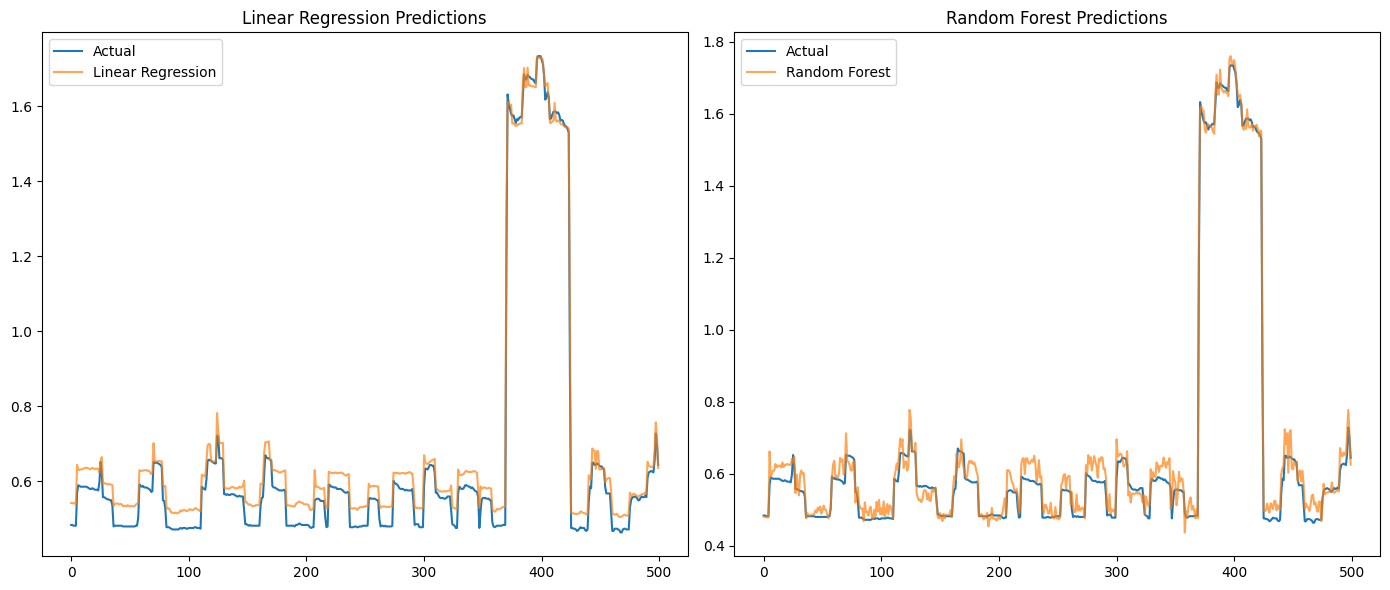

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test.values[:500], label='Actual')
plt.plot(lr_preds[:500], label='Linear Regression', alpha=0.7)
plt.title('Linear Regression Predictions')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test.values[:500], label='Actual')
plt.plot(rf_preds[:500], label='Random Forest', alpha=0.7)
plt.title('Random Forest Predictions')
plt.legend()

plt.tight_layout()
plt.show()

***Observations***

-- Linear Regression Predictions:

* Closely track the trend of actual consumption values.

* Slight underfitting or smoothing is noticeable during sudden spikes or dips.

-- Random Forest Predictions:

* Track both trends and local fluctuations more accurately.

* Capable of capturing short-term irregularities and non-linear behaviors.

***Insights***

-- Random Forest provides superior granularity in prediction, especially valuable for short-term load forecasting or anomaly detection.

-- Linear Regression, while simpler and interpretable, may miss complex interactions or time-varying effects in the data.

# 9. Conclusion

In this project, we explored the application of machine learning models to forecast household energy consumption using the UCI Household Power Consumption dataset.

--> We focused on predicting **Global Active Power**, a key metric indicating the total real power consumed in the household. After preprocessing and feature engineering (including time-based lag features), we trained and compared two regression models: **Linear Regression** and **Random Forest Regressor**.

- **Linear Regression** served as a baseline model, performing surprisingly well with an R² of 0.998 and RMSE of 0.040.
- **Random Forest Regressor** outperformed Linear Regression, achieving an R² of 0.999 and RMSE of 0.036, highlighting its ability to capture complex, non-linear relationships in the data.

--> Visual comparisons between predicted and actual energy usage confirmed that Random Forest was better at tracking sudden fluctuations in consumption, especially during peak hours.

This demonstrates that:
- **Machine learning can accurately predict short-term electricity demand**,
- **Random Forest is a strong candidate for energy forecasting tasks**, and
- Proper **data preprocessing, feature engineering**, and **model selection** play a critical role in achieving high performance.

--> Overall, this project provides a strong foundation for intelligent energy demand forecasting.


# **Summary**


- **We downloaded, explored and performed EDA** on the **UCI “Individual Household Electric Power Consumption” dataset** (≈ 2 million one-minute records from Dec 2006 – Nov 2010).  
- **Cleaned the data** by  
  - combining the `Date` + `Time` columns into a single `DateTime` index,  
  - converting power/voltage/intensity fields to numeric and dropping “?” rows,  
  - resampling to **hourly means** (≈ 142 K rows × 7 numeric columns).  
- **Engineered features** by adding 24-hour lag variables to capture temporal dependencies.  
- **Split chronologically** into **train set** (data \< 2009-01-01, ≈ 97 K rows) and **test set** (≥ 2009-01-01, ≈ 45 K rows) to avoid data-leakage.  
- **Trained a baseline Linear Regression model** to establish reference performance.  
- **Built a Random Forest Regressor**, capturing non-linear relationships and short-term fluctuations.  



- **Random Forest outperformed the baseline**, reducing error by ~10 % and explaining 99.9 % of variance.  
- **Visualization** of the first 500 test hours showed Random Forest predictions tracking real demand more closely, especially around spikes and dips.  

---

####  Possible Future Work
- Enrich the feature set (rolling means, Fourier seasonality terms, weather data).  
- Hyper-parameter tuning with GridSearch/Optuna to push RMSE even lower.  
- Evaluate time-series-specific models (ARIMA, Prophet, LSTM, Temporal Fusion Transformer).  
- Deploy as an API for real-time demand forecasting and smart-grid optimization.  
- Implement k-fold (time-series) cross-validation for more robust performance estimates.
